# Densembling - Deep Ensembling

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import random
import math
import time
import copy
import itertools
import gzip

from mnist import MNIST
from data import get_dls_MNIST

### Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parameters

In [3]:
BATCH_SIZE = 64
N_TASKS = 10
N_EPOCHS_PER_TASK = 50
TEST_ALL_TASKS = 0 # Whether the network should be jointly trained all tasks together

N_EPOCHS_TOTAL = N_TASKS * N_EPOCHS_PER_TASK

MNIST_INPUT_SIZE = 27 ** 2
MNIST_N_CLASSES = 10


# Model params
INPUT_DIM = MNIST_INPUT_SIZE
HIDDEN1_DIM = 2000
HIDDEN2_DIM = 2000
OUTPUT_DIM = MNIST_N_CLASSES
DROPOUT = 0.5

LEARNING_RATE = 0.001

## Data

### MNIST
Load MNIST dataset, normalize into values between 0 and 1 and compute permutations

In [4]:
train_dl, valid_dl, test_dl = get_dls_MNIST(BATCH_SIZE, device, small=True)

### Permutations

In [5]:
permutations = [range(MNIST_INPUT_SIZE)]
while len(permutations) < N_TASKS:
    permutations.append(np.random.permutation(MNIST_INPUT_SIZE))

## Model

In [6]:
LR_GAE = 0.01

### GAE - Gating Auto-Encoder

In [7]:
class GAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(GAE, self).__init__()
        
        self.encoder = nn.Linear(input_dim, hidden_dim)
        
        self.decoder = nn.Linear(hidden_dim, input_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.criterion = nn.MSELoss(reduction="none")
        
        self.optim = optim.Adam(self.parameters(), lr=LR_GAE)
    
    def forward(self, inp):
        #inp = [batch_size, input_size]
        
        squashed = torch.sigmoid(inp)
        
        encoded = F.relu(self.dropout(self.encoder(squashed)))
        
        #encoded = [batch_size, hidden_dim]
        
        decoded = self.dropout(self.decoder(encoded))
        
        #decoded = [batch_size, input_dim]
        return torch.sigmoid(decoded)
    
    def rec_err(self, inp, detach=False):
        #inp = [batch_size, input_dim]
        
        if detach:
            out = self(inp).detach()
        else:
            out = self(inp)
        
        errors = self.criterion(out, inp).mean(dim=-1)
        #erros =  [batch_size]
        
        return errors
    
    def train_GAE(self, inp):
        """Trains on input batch"""
        self.train()
        self.optim.zero_grad()
        
        loss = self.rec_err(inp).mean()
        
        loss.backward()
        
        self.optim.step()
        
        return loss.item()

Small test whether Gating autoencoder works


0.08376780897378922


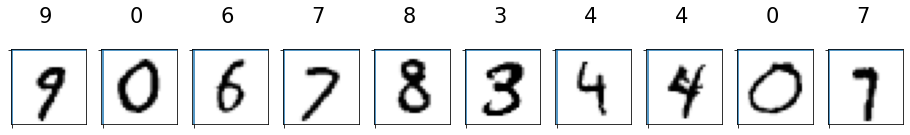

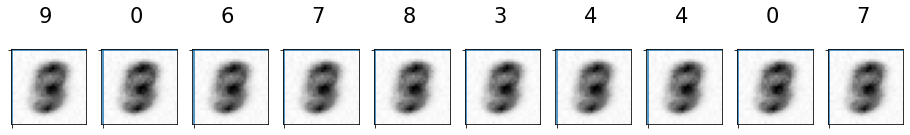

In [8]:
LR_GAE = 0.001
test = GAE(28**2, 100, 0.1)
for X, y in train_dl:
    last_error = test.train_GAE(X)
print(last_error)
    
def plotData(images, labels, n):
    """
    Prints n images with their labels from given images
    Code adapted from: https://azure.microsoft.com/de-de/services/open-datasets/catalog/mnist/
    """
    # Get images in right format:
    images = np.reshape( images, ( images.shape[0], 28, 28 ) )
    # Convert labels to digits:
    #labels = np.argmax(labels, axis=1)
    plt.figure( figsize=( 16, 6 ) )
    for i, x in enumerate(range(n)):
        plt.subplot( 1, n, i + 1 )
        plt.axhline( "" )
        plt.axvline( "" )
        plt.text( x=10, y=-10, s=labels[x].item(), fontsize=21 )
        plt.imshow( images[x], cmap=plt.cm.Greys )
    plt.show
X, y = next(iter(train_dl))
plotData(X, y, 10)

test.eval()
output = test(X).detach().numpy()
plotData(output, y, 10)

### Gating

In [9]:
class Gate(nn.Module):
    def __init__(self, input_dim_GAE, hidden_dim_GAE, dropout_GAE):
        super(Gate, self).__init__()
        self.input_dim_GAE = input_dim_GAE
        self.hidden_dim_GAE = hidden_dim_GAE
        self.dropout_GAE = dropout_GAE
        
        self.GAEs = nn.ModuleList()
        self.nGAEs = 0
        
        self.init_GAE()
        
    def forward(self, inp):
        """Returns Softmax over matching results"""
        batch_size = len(inp)
        
        gae_outputs = torch.empty((self.nGAEs, batch_size))
        for i, gae in enumerate(self.GAEs):
            gae.eval()
            gae_outputs[i] = gae.rec_err(inp)
        
        #output = [nGAEs, batch_size]
        return F.softmax(gae_outputs, dim=0)
        
    def init_GAE(self):
        nGAE = GAE(
            self.input_dim_GAE,
            self.hidden_dim_GAE,
            self.dropout_GAE
        )
        self.GAEs.append(nGAE)
        self.nGAEs += 1

In [13]:
gate = Gate(28**2, 100, 0.1)

In [14]:
gate.init_GAE()

In [15]:
gate.nGAEs

2

In [16]:
gate(X_train[0]).shape

NameError: name 'X_train' is not defined

### Expert

In [10]:
class Expert(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden1_dim,
        hidden2_dim,
        output_dim,
        dropout
    ):
        super(Expert, self).__init__()
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.output_dim = output_dim
        
        self.fc_1 = nn.Linear(input_dim, hidden1_dim)
        self.fc_2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.fc_out = nn.Linear(hidden2_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, inp):
        #inp = [batch_size, input_dim]
        
        hidden1 = self.relu(self.dropout(self.fc_1(inp)))
        hidden2 = self.relu(self.dropout(self.fc_2(hidden1)))
        output = self.fc_out(hidden2)
        
        #output = [batch_size, output_dim]
        return output

## Experiment

### schedule

In [47]:
def create_schedule(n_epochs_total, n_total_tasks, n_task_epochs):
    """Creates list of tuples: (task_id, n_task_epochs)"""
    # Creates a training schedule:
    schedule = []
    epoch_counter = n_epochs_total

    for task_id in itertools.cycle(range(n_total_tasks)):

        if epoch_counter - n_task_epochs <=0:
            schedule.append((task_id, epoch_counter))
            break
        else:
            schedule.append((task_id, n_task_epochs))
            epoch_counter -= n_task_epochs
    return schedule

def schedule_repetitions(x):
    """x amount of repetitions each task gets"""
    assert x != 0
    n_task_epochs = N_EPOCHS_TOTAL // ((N_TASKS + TEST_ALL_TASKS) * x)
    return create_schedule(N_EPOCHS_TOTAL, N_TASKS + TEST_ALL_TASKS, n_task_epochs)

In [27]:
# Low total epochs number for debugging
dbg_not_interleaved = create_schedule(100,10,10)
dbg_medium_interleaved = create_schedule(100,10,5)
dbg_strong_interleaved = create_schedule(100,10,2)

In [13]:
not_interleaved = schedule_repetitions(1)
medium_interleaved = schedule_repetitions(4)
strong_interleaved = schedule_repetitions(8)

### experiment

In [30]:
def experiment(
    experiment_name,
    n_repetitions,
    schedule,       # List of tuples: [(task_id, n_task_epochs),...]
    init_func,      # Returns tuple: model, pass_on_variable which is given to repeat_func
    repeat_func,    # Returns triple: hist_loss, hist_hits, model
    step_size_evaluation=10,
    eval_within=False # Wether evaluation happens within a task or not
):
    n_epochs_total = sum([x[1] for x in schedule])
    n_tasks_total = len(set([x[0] for x in schedule]))
    n_evaluations = sum([x[1] // step_size_evaluation for x in schedule])
    n_datasets = 3

    if eval_within:
        hist_all_losses = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_evaluations))
        hist_all_hitsss = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_evaluations))
    
    n_task_changes = len(schedule)
    
    hist_between_losses = np.empty((n_repetitions, n_tasks_total, n_datasets, n_task_changes))
    hist_between_hitsss = np.empty((n_repetitions, n_tasks_total, n_datasets, n_task_changes))

    for repetition in range(n_repetitions):
        print(f"@@@@@@@@@ Repetition {repetition:3} @@@@@@@@@")
        if repetition == 0:
            models = []

        # Call task specific init function
        pass_on_variables = init_func()
        
        model = pass_on_variables[0]
        criterion = pass_on_variables[2]

        n_evalsteps_passed = 0
        for i, (task_id, n_task_epochs) in enumerate(schedule):
            tag = f"{experiment_name}.s{i}.t{task_id}.e{n_task_epochs}"
            print(f"\nSCHEDULE: {tag}")

            # Call task specific repeat function
            hist_loss, hist_hits, model = repeat_func(n_tasks_total,
                                                      n_task_epochs,
                                                      task_id,
                                                      step_size_evaluation,
                                                      repetition,
                                                      eval_within,
                                                      pass_on_variables)

            start_idx = n_evalsteps_passed
            end_idx = n_evalsteps_passed + n_task_epochs // step_size_evaluation
            if eval_within:
                hist_all_losses[repetition,:,:,start_idx:end_idx] = hist_loss
                hist_all_hitsss[repetition,:,:,start_idx:end_idx] = hist_hits
                
            evaluate_all_tasks(model,
                               hist_between_losses[repetition],
                               hist_between_hitsss[repetition],
                               n_tasks_total,
                               i,
                               criterion, 
                               i + 1)

            if repetition == 0 and model is not None:
                models.append(copy.deepcopy(model))

            n_evalsteps_passed = end_idx

    if not eval_within:
        return hist_between_losses, hist_between_hitsss, None, None, models
    return hist_between_losses, hist_between_hitsss, hist_all_losses, hist_all_hitsss, models

## Evaluation

### evaluate

In [15]:
def evaluate(model, dataloader, permutation, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for X, y in dataloader:
            #X = [batch_size, input_dim]
            #y = [batch_size]

            output = model(X[:,permutation])
            #output = [batch_size, n_classes]
            
            loss = criterion(output, y)

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

### hitsLoss
Not for training, but for evaluation!

In [16]:
def hitsLoss(outputs, labels):
    #outputs = [batch_size, n_classes]
    #labels = [batch_size]
    
    batch_size = outputs.shape[0]
    
    preds = outputs.detach().argmax(dim=-1)
    
    hits = sum(preds == labels)/batch_size
    
    return hits

### evaluate_all_tasks

In [17]:
def evaluate_all_tasks(model, total_loss_array, total_hits_array, n_tasks_total, idx, criterion, max_task=None):
    if max_task is None or max_task > n_tasks_total:
        max_task = n_tasks_total
    for other_id in range(max_task):
        total_loss_array[other_id,0,idx] = evaluate(model,
                                                    train_dl,
                                                    permutations[other_id],
                                                    criterion)
        total_loss_array[other_id,1,idx] = evaluate(model,
                                                    valid_dl,
                                                    permutations[other_id],
                                                    criterion)
        total_loss_array[other_id,2,idx] = evaluate(model,
                                                    test_dl,
                                                    permutations[other_id],
                                                    criterion)
        total_hits_array[other_id,0,idx] = evaluate(model,
                                                    train_dl,
                                                    permutations[other_id],
                                                    hitsLoss)
        total_hits_array[other_id,1,idx] = evaluate(model,
                                                    valid_dl,
                                                    permutations[other_id],
                                                    hitsLoss)
        total_hits_array[other_id,2,idx] = evaluate(model,
                                                    test_dl,
                                                    permutations[other_id],
                                                    hitsLoss)

### epoch_time

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Plotting

### plotAccOverTasks

In [80]:
def plotAccOverTasks(hist_between_tasks, schedule, title, path=None):
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_between_tasks.shape
    assert n_task_switches == len(schedule)
    
    combined_error = np.empty((n_repetitions, n_datasets, n_task_switches))
    
    tasks_trained_on = set()
    # Get total accuracy for tasks already trained on
    for i, (task_id, _) in enumerate(schedule):
        tasks_trained_on.add(task_id)
        
        indices = list(tasks_trained_on)
        # Sum over tasks trained on
        s = np.sum(hist_between_tasks[:,indices,:,i], axis=0)

        # Divide by number of tasks
        d = s / len(tasks_trained_on)
        
        combined_error[:,:,i] = d
    
    #average runs
    hist_avg = np.average(combined_error, axis=0)
    # standard deviation
    hist_std = np.std(combined_error, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(combined_error)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(combined_error)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)
    
    ax = plt.subplot(111)
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task switches")
    ax.set_ylabel("accuracy")
    xvals = range(n_task_switches)
    
    for dataset_id in range(n_datasets):
        # Average
        ax.plot(xvals,
                hist_avg[dataset_id])
        # Stds
        ax.fill_between(xvals,
                       hist_min[dataset_id],
                       hist_max[dataset_id],
                       alpha=0.3)
    legends = np.array(["Train", "Valid", "Test"])
    plt.legend(legends)
    plt.title(title)
    plt.tight_layout()
    if path is not None:
        plt.savefig(path, dpi=300, bbox_inches='tight')

# Experiment 1: Train single expert

### train_functions

#### train_expert

In [21]:
def train_expert(model, dataloader, permutation, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for X, y in dataloader:

        optimizer.zero_grad()

        output = model(X[:,permutation])

        loss = criterion(output, y)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

#### fit

In [22]:
def fit(
    n_tasks_total,
    model,
    task_id,
    n_task_epochs,
    step_size_evaluation,
    optimizer,
    criterion,
    clip=1,
    repetition=None,
    eval_within=False
):

    total_hits = torch.zeros((n_tasks_total, 3, n_task_epochs//step_size_evaluation,))
    total_loss = torch.zeros((n_tasks_total, 3, n_task_epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)
        
        start_time = time.time()
        
        train_loss = train_expert(model, train_dl, permutations[task_id], optimizer, criterion, clip)
        valid_loss = evaluate(model, valid_dl, permutations[task_id], criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Log performance AFTER training
        if eval_within and epoch % STEP_SIZE_EVALUATION == 0 and epoch != 0:
            idx = epoch//STEP_SIZE_EVALUATION
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        
        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

#### init_func, repeat_func

In [23]:
def init_expert():

    nmodel = Expert(INPUT_DIM, HIDDEN1_DIM, HIDDEN2_DIM, OUTPUT_DIM, DROPOUT)
    optimizer = optim.Adam(nmodel.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    return (nmodel, optimizer, criterion)

def repeat_expert(n_tasks_total, n_task_epochs, task_id, step_size_evaluation, repetition, eval_within, pass_on_variables):
    model, optimizer, criterion = pass_on_variables

    hist_loss, hist_hits = fit(
        n_tasks_total,
        model,
        task_id,
        n_task_epochs,
        step_size_evaluation,
        optimizer,
        criterion,
        repetition=repetition,
        eval_within=eval_within
    )
    return hist_loss, hist_hits, model

### experiment

In [31]:
schedule = dbg_not_interleaved
n_repetitions = 2
hist_between_losses, hist_between_hitsss, _, _, models = experiment(
    "Expert Only",
    n_repetitions,
    schedule,
    init_expert,
    repeat_expert,
    eval_within=False,
)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: Expert Only.s0.t0.e10
Epoch: 01 | Time: 0m 2s | R0 T0
	Train Loss: 0.660 | Train PPL:   1.935
	 Val. Loss: 0.425 |  Val. PPL:   1.530
Epoch: 02 | Time: 0m 1s | R0 T0
	Train Loss: 0.273 | Train PPL:   1.314
	 Val. Loss: 0.265 |  Val. PPL:   1.303
Epoch: 03 | Time: 0m 1s | R0 T0
	Train Loss: 0.219 | Train PPL:   1.244
	 Val. Loss: 0.275 |  Val. PPL:   1.317
Epoch: 04 | Time: 0m 1s | R0 T0
	Train Loss: 0.140 | Train PPL:   1.151
	 Val. Loss: 0.193 |  Val. PPL:   1.213
Epoch: 05 | Time: 0m 1s | R0 T0
	Train Loss: 0.125 | Train PPL:   1.133
	 Val. Loss: 0.285 |  Val. PPL:   1.330
Epoch: 06 | Time: 0m 1s | R0 T0
	Train Loss: 0.107 | Train PPL:   1.113
	 Val. Loss: 0.228 |  Val. PPL:   1.257
Epoch: 07 | Time: 0m 1s | R0 T0
	Train Loss: 0.082 | Train PPL:   1.085
	 Val. Loss: 0.244 |  Val. PPL:   1.277
Epoch: 08 | Time: 0m 1s | R0 T0
	Train Loss: 0.075 | Train PPL:   1.078
	 Val. Loss: 0.305 |  Val. PPL:   1.357
Epoch: 09 | Time: 0m 1s | R0 T0
	Tra

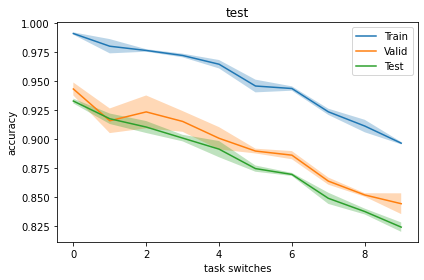

In [81]:
plotAccOverTasks(hist_between_hitsss, schedule, "test")

# Experiment 2: Synaptic intelligence